# Mask R-CNN - Inspect Neurons Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [21]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = '42'
matplotlib.rcParams['ps.fonttype'] = '42'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/nel/Code/VolPy/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.neurons import neurons

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#NEURONS_WEIGHTS_PATH = MODEL_DIR + "/neurons20190911T1303/mask_rcnn_neurons_0030.h5"  # TODO: update this path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configurations

In [74]:
config = neurons.NeuronsConfig()
NEURONS_DIR = os.path.join(ROOT_DIR, "datasets/neurons_3channel_cross1_all")

In [75]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MAX_DIM=512
    #CLASS_THRESHOLD = 0.33
    #RPN_NMS_THRESHOLD = 0.7
    #DETECTION_NMS_THRESHOLD = 0.3
    #IMAGE_SHAPE=[512, 128,3]
    RPN_NMS_THRESHOLD = 0.7
    #TRAIN_ROIS_PER_IMAGE = 1000
    POST_NMS_ROIS_INFERENCE = 1000

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_THRESHOLD                0.5
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE          

## Notebook Preferences

In [76]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [77]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [78]:
# Load validation dataset
dataset = neurons.NeuronsDataset()
dataset.load_neurons(NEURONS_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/06152017Fish1-2.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/403106_3min.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/FOV3_35um.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/FOV4_50um.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ29_S5_FOV4.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV5.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV7.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV8.npz
Images: 8
Classes: ['BG', 'neurons']


## Load Model

In [79]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [80]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()
#weights_path = MODEL_DIR + "/neurons20191203T1603/mask_rcnn_neurons_0035.h5"
#weights_path = MODEL_DIR + "/neurons20191203T1330/mask_rcnn_neurons_0045.h5"
#weights_path = MODEL_DIR + "/neurons20191203T1748/mask_rcnn_neurons_0040.h5"
#weights_path = MODEL_DIR + "/neurons20191204T1134/mask_rcnn_neurons_0040.h5"
#weights_path = MODEL_DIR + "/neurons20191204T1315/mask_rcnn_neurons_0040.h5"
#weights_path = MODEL_DIR + "/neurons20191204T1346/mask_rcnn_neurons_0040.h5"
#weights_path = MODEL_DIR + "/neurons20191205T0021/mask_rcnn_neurons_0040.h5"
weights_path = MODEL_DIR + "/neurons20191204T2351/mask_rcnn_neurons_0040.h5"
weights_path = MODEL_DIR + "/neurons20191204T2307/mask_rcnn_neurons_0040.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/nel/Code/VolPy/Mask_RCNN/logs/neurons20191204T2307/mask_rcnn_neurons_0040.h5
Re-starting from epoch 40


## Run Detection

In [81]:
prop = 'val'
dataset = neurons.NeuronsDataset()
dataset.load_neurons(NEURONS_DIR, prop)

# Must call before using the dataset
dataset.prepare()

import os 
folder = '/home/nel/Code/VolPy/Paper/'+os.path.split(os.path.split(weights_path)[0])[-1]+'/'+prop+'/'
try:
    os.makedirs(folder)
    print('make folder')
except:
    print('already exist')


/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/06152017Fish1-2.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/403106_3min.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/FOV3_35um.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/FOV4_50um.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ29_S5_FOV4.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV5.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV7.npz
/home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/IVQ48_S7_FOV8.npz
make folder


In [58]:
folder

'/home/nel/Code/VolPy/Paper/neurons20191204T2351/train/'

In [29]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [18]:
image_id = random.choice(dataset.image_ids)
image_id = 0
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection

results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: neurons.06152017Fish1-2.npz (0) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross3_all/train/06152017Fish1-2.npz
Processing 1 images
image                    shape: (384, 320, 3)         min:   -3.29693  max:   13.05967  float32
molded_images            shape: (1, 384, 320, 3)      min:   -3.29693  max:   13.05967  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 30690, 4)         min:   -0.56746  max:    1.36683  float32
gt_class_id              shape: (33,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (33, 4)               min:   10.00000  max:  372.00000  int32
gt_mask                  shape: (384, 320, 33)        min:    0.00000  max:    1.00000  bool


In [84]:
from caiman.base.rois import nf_match_neurons_in_binary_masks
performance=[]
F1 = {}
recall = {}
precision = {}
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    
    # Run object detection    
    results = model.detect([image], verbose=1)
    
    # Display results
    _, ax = plt.subplots(1,1, figsize=(16,16))
    r = results[0]
    display_result = True
    if display_result:  
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], ax=ax,
                                    title="Predictions")
        #plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_mrcnn_result.pdf')
        plt.close()
    
    mask_pr = r['masks'].copy().transpose([2,0,1])*1.
    mask_gt = gt_mask.copy().transpose([2,0,1])*1.
    
    tp_gt, tp_comp, fn_gt, fp_comp, performance_cons_off = nf_match_neurons_in_binary_masks(
            mask_gt, mask_pr, thresh_cost=0.7, min_dist=10, print_assignment=True,
            plot_results=True, Cn=image[:,:,0], labels=['GT', 'MRCNN'])
    #plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_compare.pdf')
    plt.close()
    performance.append(performance_cons_off)
    F1[dataset.image_info[image_id]['id'][:-4]] = performance_cons_off['f1_score']
    recall[dataset.image_info[image_id]['id'][:-4]] = performance_cons_off['recall']
    precision[dataset.image_info[image_id]['id'][:-4]] = performance_cons_off['precision']

image ID: neurons.06152017Fish1-2.npz (0) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/06152017Fish1-2.npz
Processing 1 images
image                    shape: (384, 320, 3)         min:   -3.29693  max:   13.05967  float32
molded_images            shape: (1, 384, 320, 3)      min:   -3.29693  max:   13.05967  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 30690, 4)         min:   -0.56746  max:    1.36683  float32
image ID: neurons.403106_3min.npz (1) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons_3channel_cross1_all/val/403106_3min.npz
Processing 1 images
image                    shape: (512, 128, 3)         min:   -1.59008  max:    8.88643  float32
molded_images            shape: (1, 512, 128, 3)      min:   -1.59008  max:    8.88643  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: 

In [22]:
ss = [performance[i]['f1_score'] for i in range(len(performance))]
[performance[i]['f1_score'] for i in range(len(performance))]

[0.7924528301886793,
 0.7010309278350515,
 0.8785046728971962,
 0.8888888888888888,
 0.8976377952755905,
 0.9761904761904762,
 0.9032258064516129,
 0.8484848484848485,
 0.5,
 0.47058823529411764,
 0.8,
 0.8,
 0.7692307692307693,
 0.7692307692307693,
 0.46153846153846156,
 0.4]

In [73]:
dict1_val

{'06152017Fish1-2': 0.6984126984126984,
 '403106_3min': 0.8695652173913043,
 'FOV3_35um': 0.9009009009009009,
 'FOV4_50um': 0.9696969696969697,
 'IVQ29_S5_FOV4': 0.2857142857142857,
 'IVQ48_S7_FOV5': 0.5,
 'IVQ48_S7_FOV7': 0.4,
 'IVQ48_S7_FOV8': 0.3333333333333333}

In [25]:
# train
print('Ahrens',sum(ss[:2])/2)
print('Svoboda',sum(ss[2:8])/6)
print('Cohen',sum(ss[8:])/len(ss[8:]))

Ahrens 0.7467418790118654
Svoboda 0.8988220813647688
Cohen 0.6213235294117647


In [24]:
# val
print('Ahrens',sum(ss[:1])/len(ss[:1]))
print('Svoboda',sum(ss[1:4])/len(ss[1:4]))
print('Cohen',sum(ss[4:])/len(ss[4:]))


Ahrens 0.7924528301886793
Svoboda 0.8228081632070455
Cohen 0.7163439301413872


In [41]:
# val
print('Ahrens',sum(ss[:1])/len(ss[:1]))
print('Svoboda',sum(ss[1:4])/len(ss[1:4]))
print('Cohen',sum(ss[4:])/len(ss[4:]))


Ahrens 0.75
Svoboda 0.8604641049968373
Cohen 0.3472222222222222


In [88]:
precision

{'06152017Fish1-2': 0.7333333333333333,
 '403106_3min': 0.9090909090909091,
 'FOV3_35um': 0.9259259259259259,
 'FOV4_50um': 1.0,
 'IVQ29_S5_FOV4': 0.2,
 'IVQ48_S7_FOV5': 0.375,
 'IVQ48_S7_FOV7': 0.25,
 'IVQ48_S7_FOV8': 0.2222222222222222}

In [20]:

image_id = 2
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection    
results = model.detect([image], verbose=1)

# Display results
_, ax = plt.subplots(1,1, figsize=(16,16))
r = results[0]
display_result = True
if display_result:  
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_mrcnn_result.pdf')
plt.close()

mask_pr = r['masks'].transpose([2,0,1])
mask_gt = gt_mask.transpose([2,0,1])

tp_gt, tp_comp, fn_gt, fp_comp, performance_cons_off = nf_match_neurons_in_binary_masks(
        mask_gt, mask_pr, thresh_cost=0.99, min_dist=10, print_assignment=True,
        plot_results=True, Cn=image[:,:,0], labels=['GT', 'MRCNN'])
plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_compare.pdf')
plt.close()
performance.append(performance_cons_off)

image ID: neurons.403106_3min.npz (2) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons/train/403106_3min.npz
Processing 1 images
image                    shape: (512, 128, 3)         min:   -1.59008  max:    8.88643  float32
molded_images            shape: (1, 512, 128, 3)      min: -125.29008  max:  -95.01357  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -2.85070  max:    3.34676  float32
[0.9868421052631579, 0.9891304347826086, 0.9896907216494846, 0.9880952380952381, 0.99, 0.9859154929577465, 0.9888888888888889, 0.9894736842105263, 0.9876543209876543, 0.9879518072289156, 0.9864864864864865, 1.0, 0.9922480620155039, 0.9887640449438202, 0.9893617021276596, 0.9859154929577465, 1.0, 0.9886363636363636, 1.0, 0.9902912621359223, 0.9910714285714286, 1.0, 0.9900990099009901, 0.9926470588235294, 0.9910714285714286, 0.9923664122137404, 1.0, 0.9940119760479041, 0.9922480620155039

In [30]:
tp_gt

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 13, 14, 15, 17, 40, 44, 46,
       47, 48, 49, 50, 51, 52, 54, 57, 58, 63, 66, 67, 68, 69, 70, 71, 72,
       74, 76])

In [17]:
# Override the training configurations with a few
# changes for inferencing.
ct = [0.2,0.3,0.4,0.5]
summary = {}
for i in ct:
    class InferenceConfig(config.__class__):
        # Run detection on one image at a time
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        DETECTION_MIN_CONFIDENCE = 0.01
        IMAGE_RESIZE_MODE = "pad64"
        IMAGE_MAX_DIM=512
        CLASS_THRESHOLD = i
        RPN_NMS_THRESHOLD = 0.7
        DETECTION_NMS_THRESHOLD = 0.3
        #IMAGE_SHAPE=[512, 128,3]
        #RPN_NMS_THRESHOLD = 0.7
        #TRAIN_ROIS_PER_IMAGE = 1000
    config = InferenceConfig()

    # Create model in inference mode
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                  config=config)

    weights_path = MODEL_DIR + "/neurons20191008T1658/mask_rcnn_neurons_0075.h5"

    # Load weights
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)

    from caiman.base.rois import nf_match_neurons_in_binary_masks
    performance=[]
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
        print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                               dataset.image_reference(image_id)))

        # Run object detection

        results = model.detect([image], verbose=1)

        # Display results
        _, ax = plt.subplots(1,1, figsize=(16,16))
        r = results[0]
        display_result = True
        if display_result:  
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                        dataset.class_names, r['scores'], ax=ax,
                                        title="Predictions")
        #plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_mrcnn_result.pdf')
        plt.close()

        mask_pr = r['masks'].transpose([2,0,1])
        mask_gt = gt_mask.transpose([2,0,1])

        tp_gt, tp_comp, fn_gt, fp_comp, performance_cons_off = nf_match_neurons_in_binary_masks(
                mask_gt, mask_pr, thresh_cost=1, min_dist=10, print_assignment=True,
                plot_results=True, Cn=image[:,:,0], labels=['GT', 'MRCNN'])
        #plt.savefig(folder +dataset.image_info[image_id]['id'][:-4]+'_compare.pdf')
        plt.close()
        performance.append(performance_cons_off)
        
    summary[i] = performance


Loading weights  /home/nel/Code/VolPy/Mask_RCNN/logs/neurons20191008T1658/mask_rcnn_neurons_0075.h5
Re-starting from epoch 75
image ID: neurons.06152017Fish1-2.npz (0) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons/val/06152017Fish1-2.npz
Processing 1 images
image                    shape: (384, 320, 3)         min:   -0.59297  max:   13.05967  float64
molded_images            shape: (1, 384, 320, 3)      min: -124.29297  max:  -90.84033  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 30690, 4)         min:   -1.13492  max:    1.93429  float32
[0.997979797979798, 0.9976580796252927, 0.9976019184652278, 0.9969879518072289, 1.0, 0.9976689976689976, 1.0, 0.99812734082397, 0.9977477477477478, 0.9981818181818182, 0.9970845481049563, 0.9980506822612085, 1.0, 0.9972527472527473, 1.0, 1.0, 0.9978354978354979, 0.9982425307557118, 1.0, 1.0, 0.9974489795918368, 0.9971264367816092, 0.9981949458483754, 0.997

[0.9925925925925926, 0.9934640522875817, 0.9944444444444445, 0.9906542056074766, 0.9921875, 0.9878048780487805, 0.9926470588235294, 0.9935483870967742, 0.9921259842519685, 1.0, 0.9912280701754386, 0.9918032786885246, 0.9896907216494846, 0.9868421052631579, 0.9873417721518988, 0.9897959183673469, 0.9922480620155039, 0.9917355371900827, 0.9908256880733946, 0.9878048780487805, 0.9895833333333334, 0.98989898989899, 0.98989898989899, 0.9947089947089947, 0.990909090909091, 0.9935064935064936, 0.9886363636363636, 0.991869918699187, 0.9915254237288136, 0.9924812030075187, 0.9939393939393939, 0.9944444444444445, 0.9948717948717949, 0.9948453608247423]
image ID: neurons.IVQ48_S7_FOV5.npz (3) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons/val/IVQ48_S7_FOV5.npz
Processing 1 images
image                    shape: (320, 128, 3)         min:   -1.60053  max:    2.87193  float64
molded_images            shape: (1, 320, 128, 3)      min: -125.30053  max: -101.02807  float64
image_metas              sh

image ID: neurons.FOV3_35um.npz (1) /home/nel/Code/VolPy/Mask_RCNN/datasets/neurons/val/FOV3_35um.npz
Processing 1 images
image                    shape: (512, 128, 3)         min:   -1.49630  max:   11.27281  float64
molded_images            shape: (1, 512, 128, 3)      min: -125.19630  max:  -92.62719  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -2.85070  max:    3.34676  float32
[1.0, 0.9923664122137404, 0.9902912621359223, 0.9936708860759493, 0.9908256880733946, 1.0, 1.0, 0.9940119760479041, 1.0, 0.9935064935064936, 0.9926470588235294, 0.9939759036144579, 0.9965034965034965, 0.9924812030075187, 0.99375, 1.0, 0.9911504424778761, 0.9931972789115646, 0.9935064935064936, 0.9908256880733946, 0.9888888888888889, 0.9893617021276596, 0.9888888888888889, 0.9897959183673469, 0.9880952380952381, 0.9888888888888889, 0.9912280701754386, 0.9917355371900827, 0.9891304347826086, 0

W1008 17:24:39.122404 140480537569088 font_manager.py:1282] findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
W1008 17:24:39.142992 140480537569088 font_manager.py:1282] findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


In [138]:
for key, performance in summary.items():
    print((sum([performance[i]['f1_score'] for i in range(len(performance))][:3]))/3)
    print([performance[i]['f1_score'] for i in range(len(performance))][:3])

0.8166718192293639
[0.6956521739130435, 0.8131868131868132, 0.9411764705882353]
0.838029975379373
[0.676923076923077, 0.8674698795180723, 0.9696969696969697]
0.8388594944150499
[0.7, 0.8641975308641975, 0.9523809523809523]
0.8376713589272633
[0.711864406779661, 0.8831168831168831, 0.9180327868852459]


In [18]:
for key, performance in summary.items():
    print((sum([performance[i]['f1_score'] for i in range(len(performance))][:3]))/3)
    print([performance[i]['f1_score'] for i in range(len(performance))][:3])

0.7773611111111111
[0.71875, 0.7333333333333333, 0.88]
0.8042509722837591
[0.7213114754098361, 0.7747747747747747, 0.9166666666666666]
0.8106203435852416
[0.7017543859649122, 0.7735849056603774, 0.9565217391304348]
0.7865241389103764
[0.6415094339622641, 0.7474747474747475, 0.9705882352941176]


## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

In [19]:
splash = neurons.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [59]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (10230,)              min:    0.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min: -338.52737  max:  279.30718  float64
positive_anchors         shape: (32, 4)               min:  -26.50967  max:  317.65685  float64
negative_anchors         shape: (0, 4)                min:             max:             float64
neutral anchors          shape: (10198, 4)            min:  -90.50967  max:  346.50967  float64
refined_anchors          shape: (32, 4)               min:   41.00000  max:  279.00003  float32


In [60]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [61]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 40920, 2)         min:    0.00001  max:    0.99999  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.14186  max:    1.04155  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.15834  max:    1.04073  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1174.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


In [62]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

IndexError: index 36508 is out of bounds for axis 0 with size 10230

In [63]:
sorted_anchor_ids.shape

(40920,)

In [64]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 1000
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1],cmap='gray',vmax=np.percentile(image,95))

In [65]:
# Show refined anchors after non-max suppression
limit = 1000
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax(),cmap='gray',vmax=np.percentile(image,95))

In [55]:
config.IMAGE_SHAPE = np.array([508,288,3])

In [56]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 2000
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax(), cmap='gray', vmax=np.percentile(image, 95))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [117]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00422  max:    0.99578  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -2.78217  max:    2.53558  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00114  max:    0.99894  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


In [116]:
config.DETECTION_NMS_THRESHOLD=0.3

In [118]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax(),cmap='gray', vmax=np.percentile(image, 95))

74 detections: ['neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons' 'neurons'
 'neurons' 'neurons' 'neurons' 'neurons']


### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [119]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal

roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
#roi_class_ids = ((mrcnn["probs"][0][:,1]>0.3)*1.).astype(np.int)

roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
724 Positive ROIs
[('BG', 276), ('neurons', 724)]


In [120]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 1000
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax(), cmap='gray', vmax=np.percentile(image, 95))

#### Apply Bounding Box Refinement

In [126]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
#ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 1000
#ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -2.78217  max:    2.53558  float32
refined_proposals        shape: (1000, 4)             min:   -1.00000  max:  507.00000  int32


#### Filter Low Confidence Detections

In [110]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 724 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  79  80  81  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 131
 132 133 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 152 154 155 156 158 159 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 188 189 190 191
 192 193 194 195 197 198 199 200 201 202 203 204 205 206 207 208 209 211
 212 213 214 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 241 242 245 246 247 248 249 250 251
 252 253 254 255 257 258 259 2

In [111]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 724:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  79  80  81  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 131
 132 133 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 152 154 155 156 158 159 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 188 189 190 191
 192 193 194 195 197 198 199 200 201 202 203 204 205 206 207 208 209 211
 212 213 214 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 241 242 245 246 247 248 249 250 251
 252 253

#### Per-Class Non-Max Suppression

In [114]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                          config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

neurons               : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  79  80  81  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 131
 132 133 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 152 154 155 156 158 159 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 188 189 190 191
 192 193 194 195 197 198 199 200 201 202 203 204 205 206 207 208 209 211
 212 213 214 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 241 242 245 246 247 248 249 250 251
 252 253 254 255 257 258 25

In [113]:
config.DETECTION_NMS_THRESHOLD=0.3

In [115]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax(),vmax=np.percentile(image, 95), cmap='gray')

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [98]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [28]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max: 1010.00000
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000
4 detections: ['balloon' 'balloon' 'balloon' 'balloon']


In [29]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (4, 28, 28)           min:    0.00000  max:    1.00000
det_masks                shape: (4, 1024, 1024)       min:    0.00000  max:    1.00000


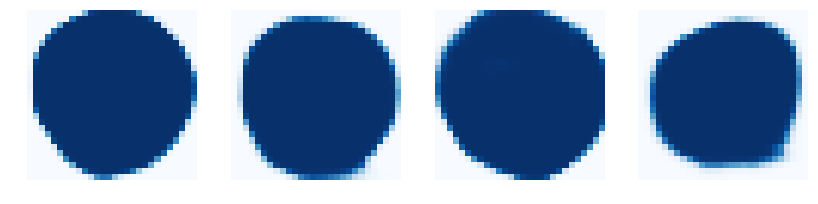

In [30]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

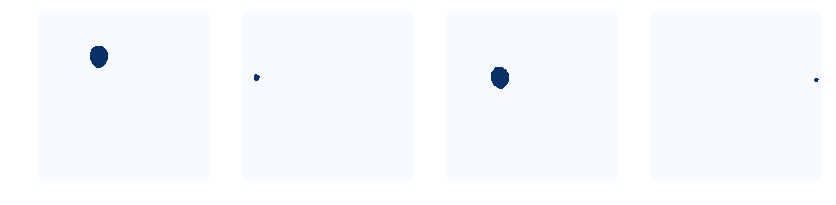

In [31]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [32]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   30.27820
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   32.50589
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   76.81063
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.21691  max:   89.27760
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


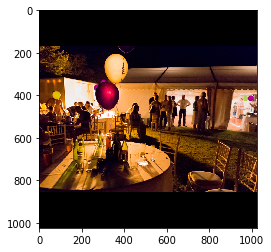

In [33]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

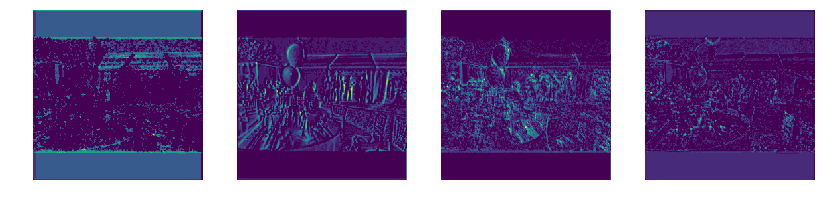

In [34]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)